after https://github.com/johnowhitaker/moar_ai_examples

In [32]:
import torch, requests, os
import numpy as np
from transformers import AutoProcessor, AutoModel
from PIL import Image
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from transformers import CLIPProcessor, CLIPModel
from tqdm.auto import tqdm
from dotenv import load_dotenv
import replicate
import warnings
warnings.filterwarnings('ignore')


## Generating Images

You could use a local generation pipeline, an API like OpenAI's Dalle-3, or something like Replicate. Since Replicate makes it easy to swap out lots of different models let's use that for now:

In [33]:
load_dotenv()
repl_token = os.getenv("REPLICATE_TOKEN")
client = replicate.Client(api_token=repl_token)  
def generate(prompt):
    output = client.run(
        "playgroundai/playground-v2.5-1024px-aesthetic:a45f82a1382bed5c7aeb861dac7c7d191b0fdf74d8d57c4a0e6ed7d4d0bf7d24",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": prompt,
            "scheduler": "DPMSolver++",
            "num_outputs": 1,
            "guidance_scale": 3,
            "apply_watermark": True,
            "negative_prompt": "ugly, deformed, noisy, blurry, distorted",
            "prompt_strength": 0.8,
            "num_inference_steps": 25
        }
    )
    return Image.open(requests.get(output[0], stream=True).raw)


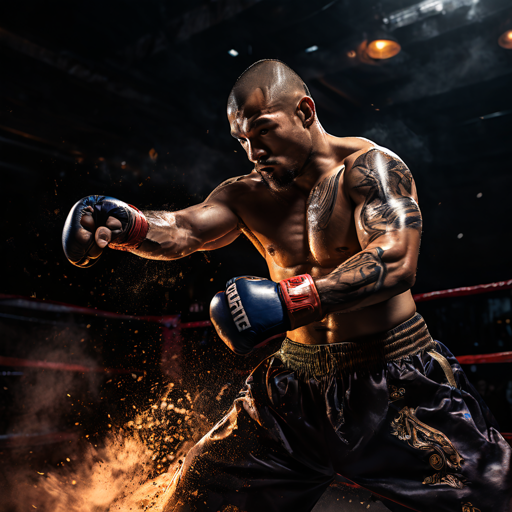

In [34]:
image = generate("Photo of a Muay Thai Fighter kicking, detailed, 8k")
image.resize((512, 512)) # Smaller preview

## Scoring Functions

These both take an image and return a score, which we can later use to rank the images.

CLIP measures similarity between the text and the image - higher is better

PickScore is trained to score (image, prompt) pairs based on user ratings of generated images. Again, higher is better. It tends to penalize things like extra limbs and artefacts.

In [35]:
# Clip score
class CLIPScorer:
    def __init__(self):
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    @torch.no_grad()
    def get_score(self, image, prompt):
        inputs = self.clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True)
        outputs = self.clip_model(**inputs)
        return outputs.logits_per_image[0].item()

In [36]:
# PickScore
class PICKScorer:
    def __init__(self):
        self.processor = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
        self.model = AutoModel.from_pretrained("yuvalkirstain/PickScore_v1").eval().to("cuda")
        #see https://arxiv.org/abs/2305.01569
    
    def get_score(self, image, prompt):
        # preprocess
        image_inputs = self.processor(
            images=image,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).to("cuda")
        
        text_inputs = self.processor(
            text=prompt,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt",
        ).to("cuda")
    
    
        with torch.no_grad():
            # embed
            image_embs = self.model.get_image_features(**image_inputs)
            image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
        
            text_embs = self.model.get_text_features(**text_inputs)
            text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
        
            # score
            scores = self.model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
           
        return scores.cpu().tolist()[0]

In [37]:
# Load the models
clip_scorer = CLIPScorer()
pick_scorer = PICKScorer()

In [38]:
# Run both scores
score1 = clip_scorer.get_score(image, "Photo of a Muay Thai Fighter kicking, detailed, 8k")
print("CLIP Score:", score1)
score2 = pick_scorer.get_score(image, "Photo of a Muay Thai Fighter kicking, detailed, 8k")
print("PickScore Score:", score2)

CLIP Score: 30.009498596191406
PickScore Score: 21.166397094726562


In [39]:
# If the prompt doesn't match the image, the score is worse:
score1 = clip_scorer.get_score(image, "A dog on mars")
print("CLIP Score:", score1)

CLIP Score: 13.384801864624023


In [40]:
pick_scorer.get_score(image, "A dog on mars")

17.5881404876709

## Generating multiple and picking the best

In [41]:
# Generate some images
prompt = "A GSXR1000 racing around a corner"
candidates = [generate(prompt) for _ in tqdm(range(10))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.22s/it]


In [42]:
# Score them all
clip_scores = [clip_scorer.get_score(image, prompt) for image in candidates]
pickscore_scores = [pick_scorer.get_score(image, prompt) for image in candidates]

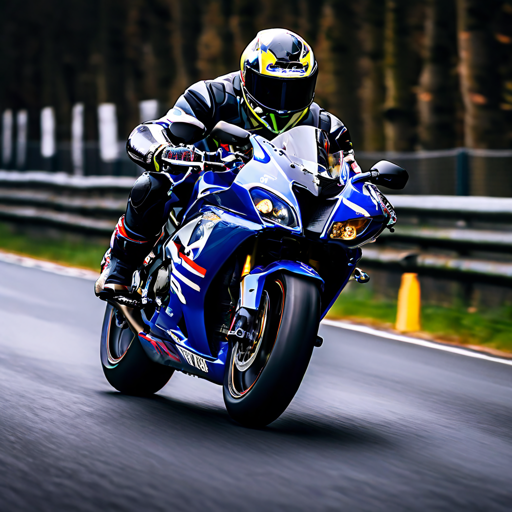

In [43]:
# Look at the best according to CLIP score
candidates[np.argmax(clip_scores)].resize((512, 512))

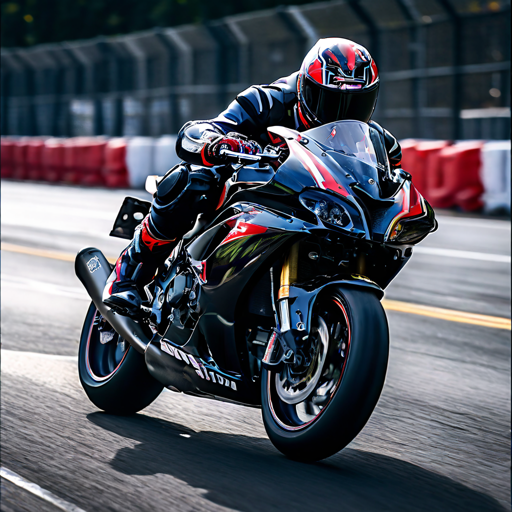

In [44]:
# Look at the best according to PickScore
candidates[np.argmax(pickscore_scores)].resize((512, 512))

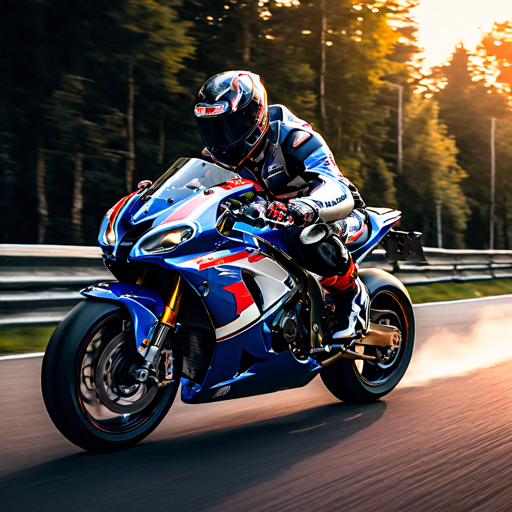

In [45]:
# And the worst:
candidates[np.argmin(pickscore_scores)].resize((512, 512))